Исслдеование выбросов. Методика:
Чтобы определить выброс необходимо построить доверительный интервал. Но делать это нужно аккуратно, чтобы не потерять важные характеристики. Поэтому доверительный интервал строится для прогнозируемой (например, усредненной величины).

1) Считаем скользящую среднюю

2) Строим для нее доверительный интервал

3) Ищем выбросы сравнивая сзначение с доверительным интервалом

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np

sns.set(
    font_scale=1.2
)

### Загрузите данные, проверьте число наблюдений и столбцов, наличие пропусков. Убедитесь, что типы данных были прочитаны правильно. При необходимости – приведите переменные к нужным типам.

In [2]:
data = pd.read_csv('london.csv', parse_dates=['timestamp'])
data.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [3]:
data.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
dtype: object

In [4]:
data.isna().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

### Постройте график по числу поездок по дате и времени.

<AxesSubplot:xlabel='timestamp', ylabel='cnt'>

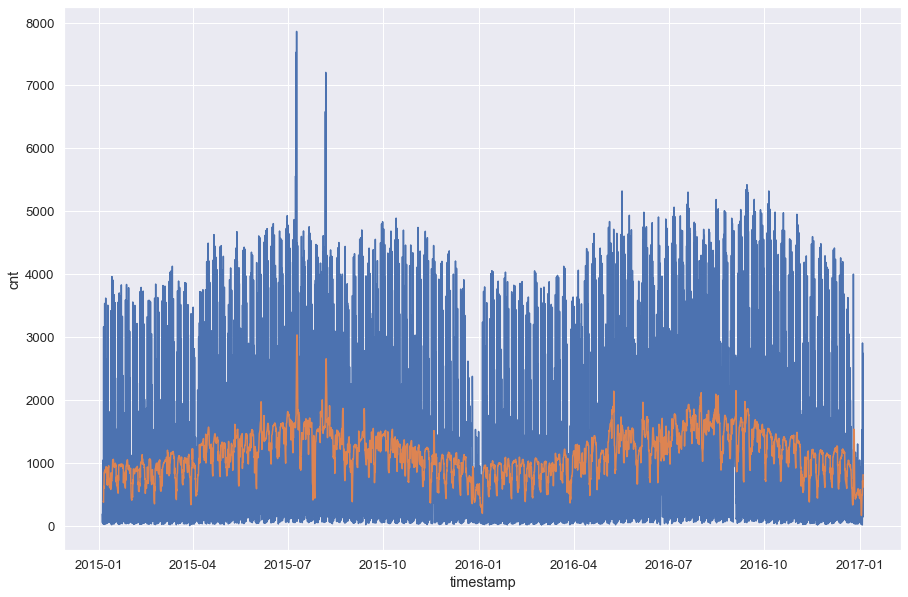

In [5]:
plt.figure(figsize=(15,10))
sns.lineplot(data=data, x='timestamp', y='cnt')
sns.lineplot(data=data, x='timestamp', y=data.cnt.rolling(24).mean())

### Преобразуйте данные и посчитайте число поездок по дням. Визуализируйте результат.

In [21]:
cnt_by_day = data \
    .resample(rule='D', on='timestamp') \
    .agg({'cnt':'sum'}) \
    .reset_index()
cnt_by_day

,timestamp,cnt
0,2015-01-04,9234
1,2015-01-05,20372
2,2015-01-06,20613
3,2015-01-07,21064
4,2015-01-08,15601
...,...,...
726,2016-12-30,11566
727,2016-12-31,11424
728,2017-01-01,6421
729,2017-01-02,11823


<AxesSubplot:xlabel='timestamp', ylabel='cnt'>

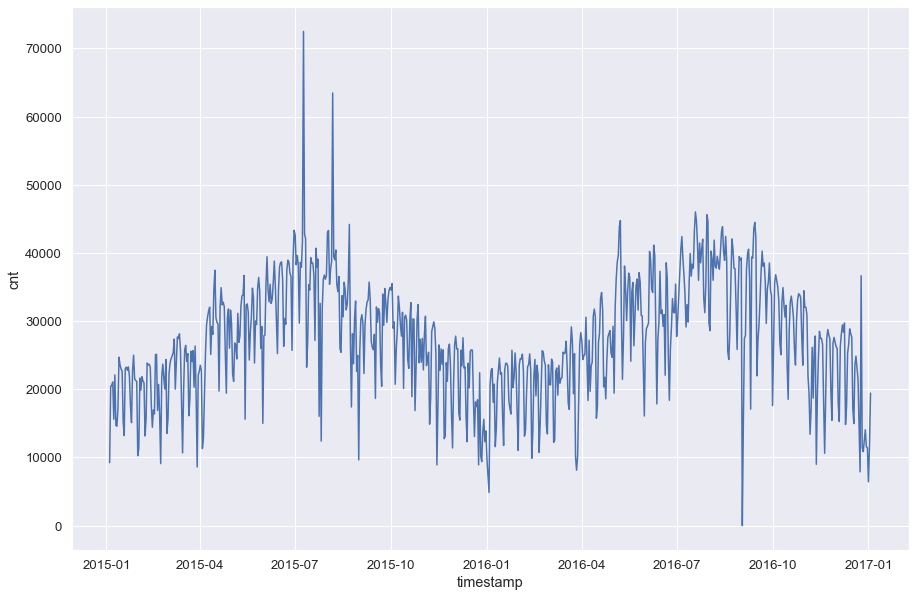

In [7]:
plt.figure(figsize=(15,10))
sns.lineplot(data=cnt_by_day, x='timestamp', y='cnt')

### Используйте агрегированные данные по дням и посчитайте скользящее среднее с окном 3. В качестве ответа укажите полученное число аренд за 2015-07-09, округлив значение до целого.

In [8]:
cnt_by_day['MA3'] = cnt_by_day.cnt.rolling(3).mean()

In [9]:
cnt_by_day \
    .query('timestamp == "2015-07-09"')

,timestamp,cnt,MA3
186,2015-07-09,72504,50705.0


Итак, вы обнаружили на графике некоторые скачки. Давайте проверим, что же могло произойти в те дни - и насколько эти изменения для нас неожиданны 🤔. Для этого мы попробуем построить доверительный интервал вокруг данных - всё, что выпадает за его пределы, будет считаться аномалией, и на отдельные из них мы потом и посмотрим.

Однако не всё так просто. Мы сейчас работаем с временным рядом - последовательностью значений, меняющейся во времени. Мы не можем просто так посчитать доверительный интервал для всего: так мы можем упустить важные характеристики данных! Например, сезонные колебания. 

Чтобы учесть этот момент, мы построим доверительный интервал, используя скользящее среднее. Для этого разделим дальнейшие действия на несколько этапов:

* сначала посчитаем скользящее среднее, чтобы сгладить ряд
* далее – разницу между наблюдаемыми и сглаженными значениями
* определим верхние и нижние границы 99% доверительного интервала 
* найдем причины аномалий!

### Посчитайте разницу между наблюдаемыми и значениями, подсчитанными с помощью скользящего среднего. Далее – найдите стандартное отклонение.

In [10]:
cnt_by_day['delta'] = cnt_by_day.cnt - cnt_by_day.MA3

In [11]:
cnt_by_day.head()

,timestamp,cnt,MA3,delta
0,2015-01-04,9234,NaN,NaN
1,2015-01-05,20372,NaN,NaN
2,2015-01-06,20613,16739.666667,3873.333333
3,2015-01-07,21064,20683.000000,381.000000
4,2015-01-08,15601,19092.666667,-3491.666667


In [12]:
cnt_by_day.delta.mean()

0.327846364883357

In [13]:
sd = round(np.std(cnt_by_day.delta), 2)

### Определите границы 99% доверительного интервала, добавьте данную информацию в датафрейм.

In [14]:
cnt_by_day['upper_bound'] = cnt_by_day.MA3 + 2.576 * sd

In [15]:
cnt_by_day['lower_bound'] = cnt_by_day.MA3 - 2.576 * sd

In [16]:
cnt_by_day \
    .query('cnt > upper_bound') \
    .sort_values('cnt', ascending=False)

,timestamp,cnt,MA3,delta,upper_bound,lower_bound
186,2015-07-09,72504,50705.000000,21799.000000,62447.927840,38962.072160
214,2015-08-06,63468,46627.333333,16840.666667,58370.261173,34884.405493
721,2016-12-25,36653,19650.666667,17002.333333,31393.594507,7907.738827
609,2016-09-04,27512,14259.000000,13253.000000,26001.927840,2516.072160


In [17]:
cnt_by_day \
    .query('cnt < lower_bound') \
    .sort_values('cnt', ascending=False)

,timestamp,cnt,MA3,delta,upper_bound,lower_bound
189,2015-07-12,23240,36036.666667,-12796.666667,47779.594507,24293.738827
621,2016-09-16,21967,36193.333333,-14226.333333,47936.261173,24450.405493
232,2015-08-24,17400,29529.333333,-12129.333333,41272.261173,17786.405493
615,2016-09-10,17080,31262.000000,-14182.000000,43004.927840,19519.072160
201,2015-07-24,16034,31013.666667,-14979.666667,42756.594507,19270.738827
130,2015-05-14,15609,28709.333333,-13100.333333,40452.261173,16966.405493
678,2016-11-12,8990,20878.000000,-11888.000000,32620.927840,9135.072160
314,2015-11-14,8898,21037.333333,-12139.333333,32780.261173,9294.405493
607,2016-09-02,0,26086.333333,-26086.333333,37829.261173,14343.405493
